In [1]:
import os
import torch
from model.faster_rcnn_vgg16 import FasterRCNNVGG16
from trainer import FasterRCNNTrainer
from data.util import read_image
from utils.vis_tool import vis_bbox
from utils import array_tool as at
%matplotlib inline

In [2]:
img = read_image('RCNN/dog-cycle-car.png')
img = torch.from_numpy(img)[None]
model_dir = 'model/'

In [3]:
faster_rcnn = FasterRCNNVGG16()
trainer = FasterRCNNTrainer(faster_rcnn).cuda()

Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/opt/conda/lib/python3.6/site-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/opt/conda/lib/python3.6/site-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/opt/conda/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/opt/conda/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chun

Exception in user code:
------------------------------------------------------------


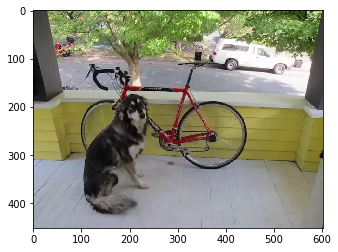

In [4]:
bboxes, labels, scores = trainer.faster_rcnn.predict(img,visualize=True)
vis_bbox(at.tonumpy(img[0]),
         at.tonumpy(bboxes[0]),
         at.tonumpy(labels[0]).reshape(-1),
         at.tonumpy(scores[0]).reshape(-1))


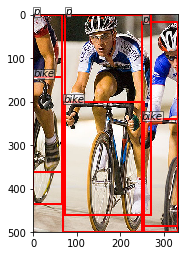

In [5]:
from PascalVOCDataloader import PascalVOCDataloader, create_split_loaders
data_dir = '/datasets/ee285f-public/PascalVOC2012/'
dataset = PascalVOCDataloader(data_dir)
image, bboxes, labels = dataset[10]
vis_bbox(at.tonumpy(image),
         at.tonumpy(bboxes),
         at.tonumpy(labels).reshape(-1))

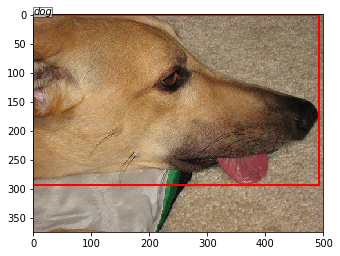

In [6]:
# Setup the training, validation, and testing dataloaders
train_loader, val_loader, test_loader = create_split_loaders(data_dir,batch_size=1)
image, bboxes, labels = next(iter(train_loader))
vis_bbox(at.tonumpy(image[0]),
         at.tonumpy(bboxes[0]),
         at.tonumpy(labels[0]).reshape(-1))

In [9]:
# Begin training loop
import numpy as np
num_epochs = 1
scale = 0.5
n_minibatch = len(train_loader)
for epoch in range(num_epochs):
    # Get the next minibatch of images, labels for training
    ave_loss = 0
    for minibatch, (images, bboxes, labels) in enumerate(train_loader, 0):
        images = 2*images/255 -1
        #print(torch.max(images), torch.min(images))
        #print('Minibatch=%d,  N_bboxes=%d' % (minibatch, bboxes.shape[1]))
        images = images.cuda()
        try:
            loss = trainer.train_step(images, bboxes, labels, scale)
        except AssertionError: 
            n_minibatch -= 1
            loss[3] = 0
            continue
        ave_loss += loss[3].item()
    print('Epoch %d, loss: %.3f' %(epoch, ave_loss/n_minibatch))
        


ValueError: Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 138, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/opt/conda/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 138, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/datasets/home/home-00/06/206/j1burke/ECE285/ECE285_Sauvage_Object_Detection/PascalVOCDataloader.py", line 86, in __getitem__
    int(bndbox_anno.find(tag).text) - 1
  File "/datasets/home/home-00/06/206/j1burke/ECE285/ECE285_Sauvage_Object_Detection/PascalVOCDataloader.py", line 86, in <listcomp>
    int(bndbox_anno.find(tag).text) - 1
ValueError: invalid literal for int() with base 10: '45.70000076293945'


In [12]:
label_map = { 'unlabeled':0,'bicycle':1,'bottle':2,'bus':3,
                        'car':4, 'cat':5,'cow':6,'dog':7,
                        'horse':8, 'motorbike':9,'person':10,
                        'sheep':11, 'train':12}
label_reverse_map = {}
for key in label_map:
    label_reverse_map[label_map[key]]=key
print(label_reverse_map)
import numpy as np

# Save
np.save('label_map.npy', label_map)
np.save('label_reverse_map.npy', label_reverse_map)

{0: 'unlabeled', 1: 'bicycle', 2: 'bottle', 3: 'bus', 4: 'car', 5: 'cat', 6: 'cow', 7: 'dog', 8: 'horse', 9: 'motorbike', 10: 'person', 11: 'sheep', 12: 'train'}


In [ ]:
read_dictionary = np.load('my_file.npy').item()